# **0. 참고자료**
## **0-1. 도서**    

## **0-2. 논문, 학술지**

## **0-3. 웹 사이트**
- DACON 코드공유 - 데이터 확인과 회전에 의한 데이터 증강 | [[링크]](https://dacon.io/competitions/official/235951/codeshare/5906?page=1&dtype=recent)
- DACON 코드 공유 - 데이터 전처리 및 학습결과 (public : 0.92) | [[링크]](https://dacon.io/competitions/official/235951/codeshare/6476?page=1&dtype=recent)

## **0-4. 데이터셋 출처**
- DACON - 숫자 3D 이미지 분류 AI 경진대회 | [[데이터 셋 링크]](https://dacon.io/competitions/official/235951/data)

# **1. 필요한 패키지 로딩**

In [1]:
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2, os
import h5py

# **2. 데이터 확인해 보기**
## **2-1. 데이터 로드**
→ 학습 데이터 셋 csv에는 이미지 인덱스 : 라벨값으로 구성되어 있다.  
→ 시험 데이터 셋 csv에는 이미지 인덱스 : 더미 라벨값으로 구성되어 있다.

In [2]:
train_df      = pd.read_csv ('../datasets/3D_MNIST/train.csv')
train_points  = h5py.File('../datasets/3D_MNIST/train.h5', 'r')

In [3]:
test_df = pd.read_csv('../datasets/3D_MNIST/sample_submission.csv')
test_points = h5py.File('../datasets/3D_MNIST/test.h5', 'r') 

- 데이터 처리 용이성을 위해 point들을 numpy array형으로 변환한다.

In [ ]:
train_points = [np.array(train_points[str(idx)]) for idx in tqdm(train_df['ID'])]
train_lb     = [lb for lb in tqdm(train_df['label'])]

test_points  = [np.array(test_points[str(i)]) for i in tqdm(test_df['ID'])]

100%|██████████| 40000/40000 [01:47<00:00, 370.52it/s]


In [21]:
def show_voxel(points, idx = None, dtype = 'train'):
    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(111, projection = '3d')

    x = points[:, 0] if idx == None else points[idx][:, 0]
    y = points[:, 1] if idx == None else points[idx][:, 1]
    z = points[:, 2] if idx == None else points[idx][:, 2]

    ax.scatter(x, y, z)
    
    lb = train_lb[idx] if idx != None else None
    lb = lb if 'train' in dtype else None
    
    ax.view_init(0, 0)
    ax.set_title(lb)
    
def rotate(theta_x, theta_y, theta_z, dots):
    mx = np.array([[1, 0, 0], [0, np.cos(theta_x), -np.sin(theta_x)], [0, np.sin(theta_x), np.cos(theta_x)]])
    my = np.array([[np.cos(theta_y), 0, np.sin(theta_y)], [0, 1, 0], [-np.sin(theta_y), 0, np.cos(theta_y)]])
    mz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0], [np.sin(theta_z), np.cos(theta_z), 0], [0, 0, 1]])
    
    m = np.dot(np.dot(mx,my),mz)
    dots = np.dot(dots, m.T)
    
    return dots


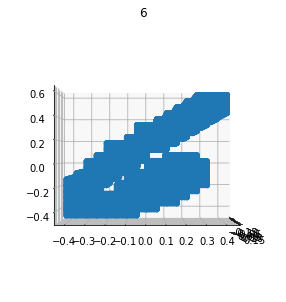

In [22]:
show_voxel(train_points, 977)

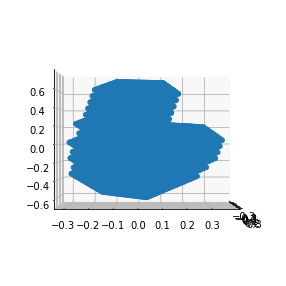

In [48]:
rotate_voxel = rotate(np.pi/6, np.pi/6, np.pi/6, train_points[977])
show_voxel(rotate_voxel)

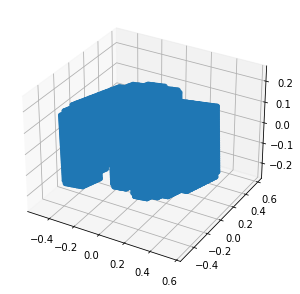

In [17]:
show_voxel(test_points, 977, dtype = 'test')

In [25]:
train_vox, valid_vox, train_lb, valid_lb = train_test_split(train_points, train_lb, shuffle = True, stratify = train_lb, 
                                                            test_size = 0.2, random_state = 42)

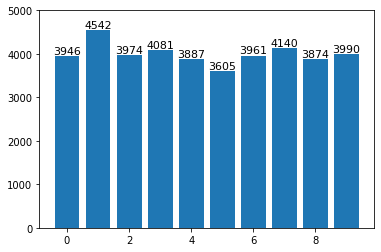

In [27]:
def get_graph(data):
    plt.bar(data.keys(), data.values())
    plt.ylim(0, 5000)

    for cnt, num in data.items():
        plt.text(cnt, num, num,
                fontsize = 11, color = 'black',
                horizontalalignment = 'center',
                verticalalignment   = 'bottom')

get_graph(Counter(train_lb))

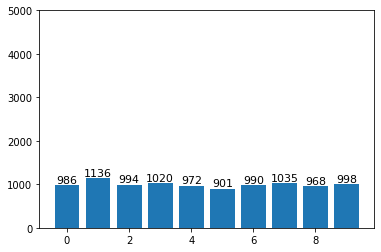

In [28]:
get_graph(Counter(valid_lb))

In [29]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch

/opt/conda/envs/bio/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
EPOCHS        = 150
BATCH_SIZE    = 64
LEARNING_RATE = 1e-3

In [31]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [32]:
class voxel_rotation(object):
    
    def __call__(self, point):
        
        angles = np.arange(np.pi / 6, 2*np.pi + np.pi / 6, np.pi / 6)
        angle_x = np.random.choice(angles)
        angle_y = np.random.choice(angles)
        angle_z = np.random.choice(angles)

        return rotate(angle_x, angle_y, angle_z, point)
    
    def __repr__(self):
        return self.__class__.__name__+'()'

In [33]:
class CustomDataset(Dataset):
    def __init__(self, labels, points):
        self.labels  = labels
        self.points  = points
        self.transforms = transforms.Compose([
                                        voxel_rotation()
                                    ])
        
    def __getitem__(self, index):
        
        points = self.points[index][:]
        # points = self.transforms(points)
        image  = self.get_vector(points)
    
        if self.labels is not None:
            label = self.labels[index]
            return torch.Tensor(image).unsqueeze(0), label
        
        else:
            return torch.Tensor(image).unsqueeze(0)
        
    def get_vector(self, points, x_y_z = [16, 16, 16]):
        
        ## Voxel Grid를 구하기 위해 각 축별 최대, 최소값 계산
        xyzmin = np.min(points, axis = 0) - 0.001
        xyzmax = np.max(points, axis = 0) + 0.001
        
        diff   = max(xyzmax-xyzmin) - (xyzmax - xyzmin)
        xyzmin = xyzmin - diff / 2
        xyzmax = xyzmax + diff / 2
        
        segments, shape = [], []
        for i in range(3):
            
            if type(x_y_z[i]) is not int: raise TypeError(f'x_y_z[{i}] must be int')
            
            s, step = np.linspace(xyzmin[i], xyzmax[i], num = (x_y_z[i] + 1), retstep = True)
            segments.append(s)
            shape.append(step)
        
        n_voxels = x_y_z[0] * x_y_z[1] * x_y_z[2]
        n_x      = x_y_z[0]
        n_y      = x_y_z[1]
        n_z      = x_y_z[2]
        
        structure = np.zeros((len(points), 4), dtype = int)
        structure[:,0] = np.searchsorted(segments[0], points[:,0]) - 1
        structure[:,1] = np.searchsorted(segments[1], points[:,1]) - 1
        structure[:,2] = np.searchsorted(segments[2], points[:,2]) - 1

        # i = ((y * n_x) + x) + (z * (n_x * n_y))
        structure[:,3] = ((structure[:,1] * n_x) + structure[:,0]) + (structure[:,2] * (n_x * n_y))
        
        vector = np.zeros(n_voxels)
        count = np.bincount(structure[:,3])
        vector[:len(count)] = count

        vector = vector.reshape(n_z, n_y, n_x)
        return vector

    def __len__(self):
        return len(self.points)

In [34]:
train_dataset = CustomDataset(train_lb, train_vox)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(valid_lb, valid_vox)
val_loader  = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

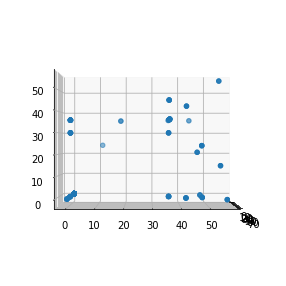

In [45]:
train_iter = iter(train_loader)
vox, lb    = next(train_iter)
show_voxel(vox[63])

In [40]:
train_sample = iter(train_loader)
image, _     = next(train_sample)
image.size()

torch.Size([64, 1, 16, 16, 16])

In [13]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel,self).__init__()
        self.feature_extract = nn.Sequential(
            nn.Conv3d(1,8,3),
            nn.ReLU(),
            nn.BatchNorm3d(8),
            nn.Conv3d(8,32,3),
            nn.ReLU(),
            nn.BatchNorm3d(32),
            nn.MaxPool3d(4),
            nn.Conv3d(32,128,3),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
                                nn.Linear(128, 64),
                                nn.ReLU(),
                                nn.Dropout(p = 0.3),
                                nn.Linear(64, 32),
                                nn.ReLU(),
                                nn.Dropout(p = 0.3),
                                nn.Linear(32, 10)
                            )

    def forward(self,x):
        x = self.feature_extract(x)
        x = x.view(x.size()[0],-1)
        x = self.classifier(x)
        return x

In [14]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_planes, planes, stride = 1):
        
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1   = nn.BatchNorm3d(planes)
        
        self.conv2 = nn.Conv3d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2   = nn.BatchNorm3d(planes)
        
        self.shortcut = nn.Sequential()
        condition = [stride != 1, in_planes != planes]
        
        if any(condition):
            self.shorcut = nn.Sequential(
                            nn.Conv3d(in_planes, planes, kernel_size = 1, stride = stride,
                                        bias = False),
                            nn.BatchNorm3d(planes)
                        )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        print(1, out.size())
        
        out = self.bn2(self.conv2(out))
        
        print(2, out.size())
        out += self.shortcut(x)
        
        print(3, out.size())
        out = F.relu(out)
        
        print(4, out.size())
        return out

In [15]:
class ResNetV(nn.Module):
    
    def __init__(self, num_classes = 10):
        
        super(ResNetV, self).__init__()
        self.in_planes = 8
        
        self.conv1 = nn.Conv3d(1, 8, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1   = nn.BatchNorm3d(8)
        
        self.residual1 = self._make_block(8, 2, stride = 1)
        self.residual2 = self._make_block(16, 2, stride = 2)
        self.residual3 = self._make_block(32, 2, stride = 2)
        self.linear    = nn.Linear(32, num_classes)
       
    
    def _make_block(self, planes, num_blocks, stride):
        
        strides = [stride] + []*(num_blocks - 1)
        layers  = []
        
        for stride in strides:
            layers.append(ResidualBlock(self.in_planes, planes, stride))
            self.in_planes = planes
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.residual1(out)
        out = self.residual2(out)
        out = self.residual3(out)
        
        out = F.avg_pool3d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [24]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    best_score = 0
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = []
        for data, label in train_loader:
            data, label = data.float().to(device), label.long().to(device)
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        if scheduler is not None:
            scheduler.step()
            
        val_loss, val_acc = validation(model, criterion, val_loader, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss)}] Val Loss : [{val_loss}] Val ACC : [{val_acc}]')
        
        if best_score < val_acc:
            best_score = val_acc
            torch.save(model.state_dict(), './best_model.pth')

In [25]:
def validation(model, criterion, val_loader, device):
    model.eval()
    true_labels = []
    model_preds = []
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(val_loader)):
            data, label = data.float().to(device), label.long().to(device)
            
            model_pred = model(data)
            loss = criterion(model_pred, label)
            
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
    
    return np.mean(val_loss), accuracy_score(true_labels, model_preds)

In [26]:
model = ResNetV()
model

ResNetV(
  (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (residual2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 

In [ ]:
model = ResNetV()
model.eval()

optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 1e-6)

train(model, optimizer, train_loader, val_loader, scheduler, device)

In [21]:
test_dataset = CustomDataset(None, test_points)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [22]:
checkpoint = torch.load('./best_model.pth')
model = BaseModel()
model.load_state_dict(checkpoint)
model.eval()

BaseModel(
  (feature_extract): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (4): ReLU()
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool3d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (7): Conv3d(32, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (8): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [23]:
def predict(model, test_loader, device):
    model.to(device)
    model.eval()
    model_preds = []
    with torch.no_grad():
        for data in tqdm(iter(test_loader)):
            data = data.float().to(device)
            
            batch_pred = model(data)
            
            model_preds += batch_pred.argmax(1).detach().cpu().numpy().tolist()
    
    return model_preds

In [24]:
preds = predict(model, test_loader, device)

100%|██████████| 2500/2500 [02:24<00:00, 17.34it/s]


In [25]:
test_df['label'] = preds
test_df.to_csv('submit/submit.csv', index=False)

## **3D 이미지를 2D 이미지로 바꿔서 해보자**

In [16]:
from sklearn.metrics import classification_report
from sklearn .decomposition import PCA
from PIL import Image
import io

In [17]:
def decomposition(voxel, pca, dtype = 'train'):
    
    image = pca.fit_transform(voxel)
    x, y  = image[:, 0], image[:, 1]
    
    fig = plt.figure(figsize = (1, 1))
    plt.scatter(x, y, s = 0.1)
    plt.axis(False)
    plt.close()
    
    return get_image_from_fig(fig, dtype = dtype)

def get_image_from_fig(fig, dpi = 32, dtype = 'train'):
    
    buf = io.BytesIO()
    fig.savefig(buf, format = 'jpg', dpi = dpi)
    buf.seek(0)
    
    image = np.frombuffer(buf.getvalue(), dtype = np.uint8)
    buf.close()
    
    image = cv2.imdecode(image, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return image

def RotateImage(image, angle, scale = 1):
    
    if image.ndim > 2: h, w, c = image.shape
    else: h, w = image.shape
    
    matrix = cv2.getRotationMatrix2D((w / 2, h / 2), angle, scale)
    result = cv2.warpAffine(image, matrix, (w, h))
    
    return result

In [18]:
pca    = PCA(n_components = 2)
images, labels = [], []
images_append  = images.append
labels_append  = labels.append
angles = np.arange(np.pi / 6, 2*np.pi + np.pi / 6, np.pi / 6)

for voxel, lb in tqdm(zip(train_points, train_lb)):
    image = decomposition(voxel, pca)
    
    for angle in angles:
        rot_image = RotateImage(image, angle)
        images_append(rot_image)
        labels_append(lb)

50000it [25:16, 32.97it/s]


In [20]:
images = np.array(images)
labels = np.array(labels)

images.shape, labels.shape

((600000, 32, 32), (600000,))

In [21]:
train_image, valid_image, train_lb, valid_lb = train_test_split(images, labels, shuffle = True, stratify = labels, 
                                                            test_size = 0.2, random_state = 99)

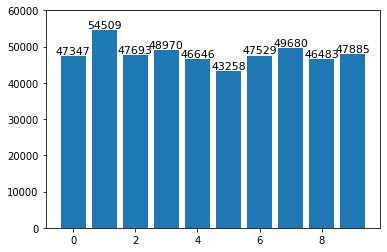

In [33]:
def get_graph(data):
    plt.bar(data.keys(), data.values())
    plt.ylim(0, 60000)

    for cnt, num in data.items():
        plt.text(cnt, num, num,
                fontsize = 11, color = 'black',
                horizontalalignment = 'center',
                verticalalignment   = 'bottom')
        
get_graph(Counter(train_lb))

In [22]:
class FlattenDataset(Dataset):
    
    def __init__(self, images, labels = None, dtype = 'train'):
        
        self.images = images
        self.labels = labels
        
        self.transforms = {}
        self.transforms['train'] = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((32, 32)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomVerticalFlip(),
                                        transforms.ToTensor()
                                    ])
        
        self.transforms['valid'] = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((32, 32)),
                                        transforms.ToTensor()
                                    ])
        
        self.num_datas = self.labels.shape[0]
        self.dtype     = dtype
        
        
    def __getitem__(self, index):
        
        image, lb = self.images[index], self.labels[index]
        image     = self.transforms[self.dtype](image)
        
        return image, lb
    
    def __len__(self):
        return self.num_datas

(-0.5, 31.5, 31.5, -0.5)

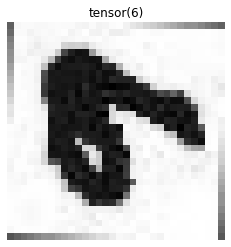

In [23]:
train_dataset = FlattenDataset(train_image, train_lb)
train_loader  = DataLoader(train_dataset, batch_size = BATCH_SIZE)

train_iter     = iter(train_loader)
images, labels = next(train_iter)

image = images[32]
label = labels[32]

plt.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
plt.title(label)
plt.axis(False)

(-0.5, 31.5, 31.5, -0.5)

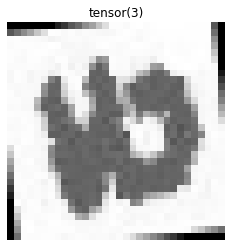

In [24]:
valid_dataset = FlattenDataset(valid_image, valid_lb, dtype = 'valid')
valid_loader  = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

valid_iter     = iter(valid_loader)
images, labels = next(valid_iter)

image = images[32]
label = labels[32]

plt.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
plt.title(label)
plt.axis(False)

In [25]:
## ResNet 모델 구성
class ResNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ResNet, self).__init__()
    ## layer1 층이 받는 채널의 개수가 16개 이므로 in_planes 변수를 16으로 초기화
    self.in_planes = 16

    ## 3 x 3 커널 크기를 가지면 3색의 채널을 16개로 만들어줌.
    self.conv1   = nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn1     = nn.BatchNorm2d(16)

    ## 16채널 -> 16채널로 내보내는 Residual Block 2개
    self.layers1 = self._make_block(16, 2, stride = 1)

    ## 16채널 -> 32채널로 내보내는 Residual Block 2개
    self.layers2 = self._make_block(32, 2, stride = 2)

    ## 32채널 -> 64채널로 내보내는 Residual Block 2개
    self.layers3 = self._make_block(64, 2, stride = 2)
    
    self.dropout  = nn.Dropout2d()
    self.linear1  = nn.Linear(64, 32)
    self.linear2  = nn.Linear(32, num_classes)

  def _make_block(self, planes, num_blocks, stride):
    strides = [stride] + []*(num_blocks - 1)
    layers  = []

    for stride in strides:
      layers.append(ResidualBlock(self.in_planes, planes, stride))
      self.in_planes = planes
    
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layers1(out)
    out = self.layers2(out)
    out = self.layers3(out)

    out = F.avg_pool2d(out, 8)
    out = out.view(out.size(0), -1)
    
    out = F.relu(self.linear1(out))
    out = self.dropout(out)
    
    out = F.relu(self.linear2(out))
    out = out

    return out

In [26]:
## Residual 블럭 구성
class ResidualBlock(nn.Module):

  def __init__(self, in_planes, planes, stride = 1):
    super(ResidualBlock, self).__init__()
    
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3,
                            stride = stride, padding = 1, bias = False)
    self.bn1   = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3,
                            stride = 1, padding = 1, bias  = False)
    self.bn2   = nn.BatchNorm2d(planes)

    ## ResNet의 두 번째 블록부터 in_planes를 받아 self.bn2 계층의 출력 크기와 같은
    ## planes와 더해주는 self.shortcut 모듈 정의

    ## nn.Sequential은 여러 모듈을 하나의 모듈로 묶는 역할
    ## 각 레이어를 데이터가 순차적으로 지나갈 때 사용하면 코드를 간결하게 사용할 수 있음.
    self.shortcut = nn.Sequential()
    condition = [stride != 1, in_planes != planes]
    
    if any(condition):
      self.shortcut = nn.Sequential(
                      nn.Conv2d(in_planes, planes,
                                kernel_size = 1, stride = stride, bias = False),
                                nn.BatchNorm2d(planes)
                    )
      

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))

      ## stride = 1이므로, in_planes와 planes가 다른 경우 shortcut층을 더해줌.
      out += self.shortcut(x)
      out = F.relu(out)

      return out

In [29]:
model     = ResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum = 0.9)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20, eta_min = 1e-6)

In [30]:
def train(model, train_loader, optimizer):
  model.train()
  train_loss, correct = 0, 0

  for batch_idx, (img, lb) in enumerate(tqdm(train_loader)):
    img, lb   = img.to(device), lb.to(device)
    optimizer.zero_grad()


    output = model(img)
    loss   = F.cross_entropy(output, lb)

    loss.backward()
    optimizer.step()
    
    pred     = output.max(1, keepdim = True)[1]
    correct   += pred.eq(lb.view_as(pred)).sum().item()
    train_loss += loss 

  train_loss /= len(train_loader.dataset)
  train_acc   = 100 * correct / len(train_loader.dataset)

  return train_loss, train_acc


def evaluate(model, test_loader):
  model.eval()
  test_loss, correct = 0, 0

  with torch.no_grad():
    for data, lb in tqdm(test_loader):
      data, lb = data.to(device), lb.to(device)
      output   = model(data)

      test_loss += F.cross_entropy(output, lb, reduction = 'sum').item()
      pred     = output.max(1, keepdim = True)[1]
      correct += pred.eq(lb.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_acc   = 100 * correct / len(test_loader.dataset)
  return test_loss, test_acc

In [ ]:
best_score = 0.0
for epoch in range(1, EPOCHS + 1):
  # scheduler.step()
  
  print(f'[{epoch} / {EPOCHS}]')
  train_loss, train_acc = train(model, train_loader, optimizer)
  vali_loss, vali_acc   = evaluate(model, valid_loader)

  if best_score < vali_acc:
    best_score = vali_acc
    torch.save(model.state_dict(), './best_model.pth')

  print(f'Train Loss : {train_loss:.3f} | Train Acc : {train_acc:.3f} \nTest Loss : {vali_loss:.3f} | Test Acc : {vali_acc:.3f}\n')

In [29]:
test_images = []
for voxel in tqdm(test_points):
    image = decomposition(voxel, pca)
    test_images.append(image)

100%|██████████| 40000/40000 [28:19<00:00, 23.53it/s]  


In [30]:
class FlattenDataset(Dataset):
    
    def __init__(self, images):
        
        self.images = images
        self.transforms = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize((32, 32)),
                                                transforms.ToTensor()
                                            ])
        
        self.num_datas = self.images.shape[0]

        
    def __getitem__(self, index):
        
        image     = self.images[index]
        image     = self.transforms(image)
        
        return image
    
    def __len__(self):
        return self.num_datas

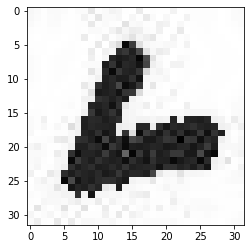

In [32]:
test_images = np.array(test_images)
test_dataset = FlattenDataset(test_images)
test_loader  = DataLoader(test_dataset, batch_size = BATCH_SIZE)

test_iter    = iter(test_loader)
images       = next(test_iter)

plt.imshow(np.transpose(images[0], (1, 2, 0)), cmap = 'gray')

In [33]:
def predict(model, test_loader, device):
    model.to(device)
    model.eval()
    model_preds = []
    with torch.no_grad():
        for data in tqdm(iter(test_loader)):
            data = data.float().to(device)
            
            batch_pred = model(data)
            
            model_preds += batch_pred.argmax(1).detach().cpu().numpy().tolist()
    
    return model_preds

In [34]:
preds = predict(model, test_loader, device)

100%|██████████| 625/625 [00:06<00:00, 95.18it/s] 


In [35]:
test_df['label'] = preds
test_df.to_csv('submit/submit.csv', index=False)